#### Medium blog link

https://medium.com/@samarthgoenka/aws-project-3-transfer-learning-with-vgg19-be41645af5bf

In [1]:
import numpy as np 
import pandas as pd 
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
import os
import cv2
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_SIZE = 224
NUM_CLASSES = 120
SEED = 19
data_dir = 'dog_breed'
labels = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
sample_sub = pd.read_csv(os.path.join(data_dir,'sample_submission.csv'))

print(len(os.listdir(os.path.join(data_dir, 'train'))), len(labels))
print(len(os.listdir(os.path.join(data_dir, 'test'))))

10222 10222
10357


In [3]:
targets_series = pd.Series(labels['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [4]:
im_size = 90

In [5]:
x_train = []
y_train = []
x_test = []

i = 0 
for f, breed in labels.values:
    img = cv2.imread('dog_breed/train/{}.jpg'.format(f))
    label = one_hot_labels[i]
    x_train.append(cv2.resize(img, (im_size, im_size)))
    y_train.append(label)
    i += 1

In [6]:
for f in sample_sub['id'].values:
    img = cv2.imread('dog_breed/test/{}.jpg'.format(f))
    x_test.append(cv2.resize(img, (im_size, im_size)))

In [7]:
y_train_raw = np.array(y_train, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255.
x_test  = np.array(x_test, np.float32) / 255.
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_test.shape)

(10222, 90, 90, 3)
(10222, 120)
(10357, 90, 90, 3)


In [8]:
num_class = y_train_raw.shape[1]

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_raw, test_size=0.3, random_state=1)

In [10]:
# Create the base pre-trained model
# Can't download weights in the kernel
base_model = VGG19(weights='imagenet',include_top=False, input_shape=(im_size, im_size, 3))

# Add a new top layer
x = base_model.output
x = Dropout(0.2)(x)
x = Flatten()(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 90, 90, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 90, 90, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 90, 90, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 45, 45, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 45, 45, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 45, 45, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 22, 128)       0         
__________

In [11]:
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_valid, Y_valid), verbose=1)

Train on 7155 samples, validate on 3067 samples
Epoch 1/5
7155/7155 [==============================] - 27s 4ms/step - loss: 4.7048 - acc: 0.0403 - val_loss: 4.3255 - val_acc: 0.0737
Epoch 2/5
7155/7155 [==============================] - 25s 3ms/step - loss: 3.7490 - acc: 0.1613 - val_loss: 4.1455 - val_acc: 0.1089
Epoch 3/5
7155/7155 [==============================] - 25s 3ms/step - loss: 3.2666 - acc: 0.2532 - val_loss: 4.0683 - val_acc: 0.1161
Epoch 4/5
7155/7155 [==============================] - 25s 3ms/step - loss: 2.9238 - acc: 0.3270 - val_loss: 4.0764 - val_acc: 0.1164
Epoch 5/5
7155/7155 [==============================] - 25s 3ms/step - loss: 2.6432 - acc: 0.3944 - val_loss: 3.9959 - val_acc: 0.1272


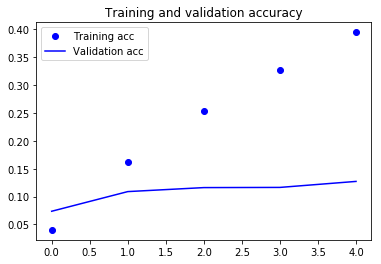

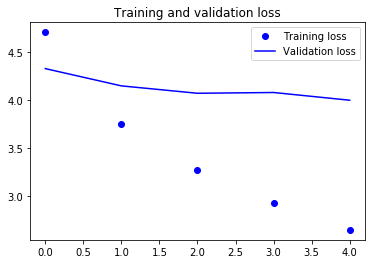

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [111]:
from keras.preprocessing.image import load_img, img_to_array

for i in range(len(os.listdir(os.path.join(data_dir, 'train')))):
    img_path1 = str(os.listdir(os.path.join(data_dir, 'train'))[i+4])
    img_path2 = str(os.listdir(os.path.join(data_dir, 'train'))[i+5])
    break

# This is the path to the image you want to transform.
target_image_path = 'dog_breed/train/'+img_path1

# This is the path to the style image.
style_reference_image_path = '89f93f0728e02b49a4b7a591ecaa0ba218651ab9jpg1072x0_q85_upscale.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size

img_height = 400
img_width = int(width * img_height / height)

In [75]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [76]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Model loaded.


In [78]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [79]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [80]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [81]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [82]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])


class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [94]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations2 = 2
iterations5 = 5
iterations10 = 10

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations2):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img2 = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img2)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations5):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img5 = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img5)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations10):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img10 = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img10)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 3634045200.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 14s
Start of iteration 1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:26: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 1473896400.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 15s
Start of iteration 0
Current loss value: 3640428500.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 15s
Start of iteration 1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:43: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 1427063400.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 15s
Start of iteration 2
Current loss value: 949557400.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 15s
Start of iteration 3
Current loss value: 731637800.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 15s
Start of iteration 4
Current loss value: 625096000.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 15s
Start of iteration 0
Current loss value: 3638698500.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 15s
Start of iteration 1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:60: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 1448046100.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 16s
Start of iteration 2
Current loss value: 928823000.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 15s
Start of iteration 3
Current loss value: 739367550.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 15s
Start of iteration 4
Current loss value: 616450200.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 15s
Start of iteration 5
Current loss value: 551312500.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 15s
Start of iteration 6
Current loss value: 510066240.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 15s
Start of iteration 7
Current loss value: 477674240.0
Image saved as style_transfer_result_at_iteration_7.png
Iteration 7 completed in 15s
Start of iteration 8
Current loss value: 447701570.0
I

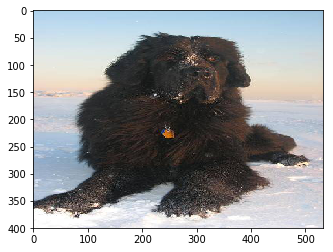

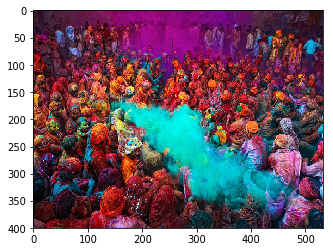

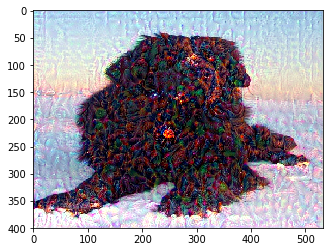

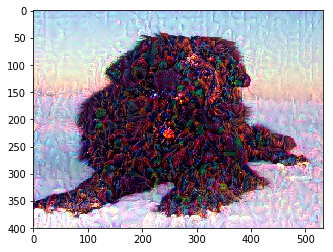

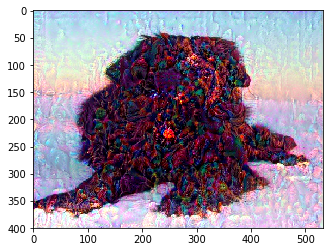

In [95]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()


# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img2)
plt.show()

plt.imshow(img5)
plt.show()

plt.imshow(img10)
plt.show()

In [106]:
target_image_path = 'dog_breed/train/'+img_path2

In [107]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Model loaded.


In [108]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [115]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations2 = 2
iterations5 = 5
iterations10 = 10

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
# x = preprocess_image(target_image_path)
# x = x.flatten()
# for i in range(iterations2):
#     print('Start of iteration', i)
#     start_time = time.time()
#     x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
#                                      fprime=evaluator.grads, maxfun=20)
#     print('Current loss value:', min_val)
#     # Save current generated image
#     img = x.copy().reshape((img_height, img_width, 3))
#     img22 = deprocess_image(img)
#     fname = result_prefix + '_at_iteration_%d.png' % i
#     imsave(fname, img22)
#     end_time = time.time()
#     print('Image saved as', fname)
#     print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations5):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img55 = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img55)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    
x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations10):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img101 = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img101)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 2738497300.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 16s
Start of iteration 1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:43: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 1093628400.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 17s
Start of iteration 2
Current loss value: 785703600.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 17s
Start of iteration 3
Current loss value: 595350850.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 17s
Start of iteration 4
Current loss value: 503972350.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 17s
Start of iteration 0
Current loss value: 2752308500.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 17s
Start of iteration 1


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:60: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Current loss value: 1084711000.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 17s
Start of iteration 2
Current loss value: 768186940.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 17s
Start of iteration 3
Current loss value: 621599100.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 17s
Start of iteration 4
Current loss value: 510353700.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 17s
Start of iteration 5
Current loss value: 453243040.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 17s
Start of iteration 6
Current loss value: 402887840.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 17s
Start of iteration 7
Current loss value: 369165600.0
Image saved as style_transfer_result_at_iteration_7.png
Iteration 7 completed in 17s
Start of iteration 8
Current loss value: 335055800.0
I

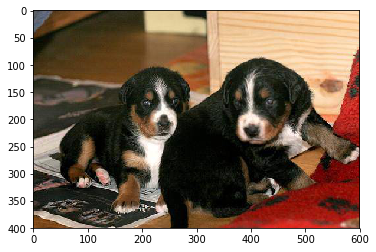

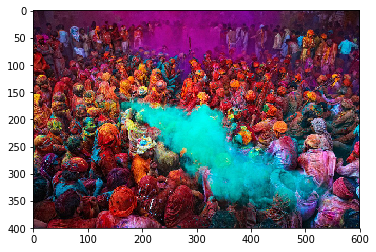

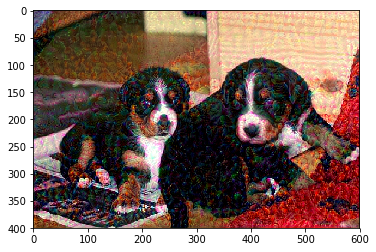

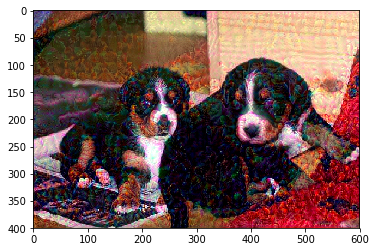

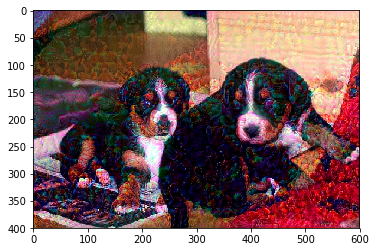

In [116]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()


# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img22)
plt.show()

plt.imshow(img55)
plt.show()

plt.imshow(img101)
plt.show()

In [117]:
print(img_path1)
print(img_path2)

369f1231c318aafcdcb56a0cdd63b5f0.jpg
4d78f6722feb2c8487c0642a4bbeaa86.jpg
